In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("/kaggle/input/data-open-2023-additional-data/merged_data_onehot2.csv")
df.dropna(inplace=True)
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.sort_values(["year_month", "DIST_NUM"], inplace=True)
df

,year_month,DIST_NUM,crime_total,VEHICLE_COUNT,ILLUMINATION_1.0,ILLUMINATION_2.0,ILLUMINATION_3.0,ILLUMINATION_4.0,ILLUMINATION_5.0,ILLUMINATION_6.0,ILLUMINATION_8.0,ILLUMINATION_9.0,ILLUMINATION_nan,INTERSECT_TYPE_0,INTERSECT_TYPE_1,INTERSECT_TYPE_10,INTERSECT_TYPE_11,INTERSECT_TYPE_12,INTERSECT_TYPE_2,INTERSECT_TYPE_3,INTERSECT_TYPE_5,INTERSECT_TYPE_6,INTERSECT_TYPE_7,INTERSECT_TYPE_9,LOCATION_TYPE_0,LOCATION_TYPE_1,LOCATION_TYPE_2,LOCATION_TYPE_3,LOCATION_TYPE_4,LOCATION_TYPE_5,LOCATION_TYPE_6,LOCATION_TYPE_7,LOCATION_TYPE_8,LOCATION_TYPE_99,ROAD_CONDITION_0,ROAD_CONDITION_1,ROAD_CONDITION_2,ROAD_CONDITION_3,ROAD_CONDITION_4,ROAD_CONDITION_5,ROAD_CONDITION_6,ROAD_CONDITION_7,ROAD_CONDITION_8,ROAD_CONDITION_9,ROAD_CONDITION_98,ROAD_CONDITION_99,WEATHER1_10,WEATHER1_2,WEATHER1_3,WEATHER1_4,WEATHER1_5,WEATHER1_6,WEATHER1_7,WEATHER1_8,WEATHER1_9,WEATHER1_98,WEATHER1_99,traffic_stop_total
0,2014-01,1.0,5.416100,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5.948035
1,2014-01,1.0,5.416100,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5.948035
2,2014-01,1.0,5.416100,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5.948035
3,2014-01,1.0,5.416100,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5.948035
4,2014-01,1.0,5.416100,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,5.948035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48314,2018-04,39.0,6.514713,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,6.976348
48315,2018-04,39.0,6.514713,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.976348
48316,2018-04,39.0,6.514713,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.976348
48317,2018-04,39.0,6.514713,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.976348


In [3]:
# df = pd.read_csv("/kaggle/input/data-open-2023-additional-data/df_merged_v3_v2.csv")
# df.dropna(inplace=True)
# df.drop(columns={"Unnamed: 0", "index"}, inplace=True)
# df.sort_values(["year_month", "DIST_NUM"], inplace=True)
# df

In [4]:
# count_cols = df.filter(regex='(?i)count').columns.tolist()

In [5]:
# # Categorical Columns Dataframe
# included_cols = list(set(df.columns) - set(count_cols))
# ohe_cols = [i for i in included_cols if i not in ["year_month", "DIST_NUM", "tmp_idx", "index"]]

In [6]:
# df = pd.get_dummies(data=df, columns=ohe_cols)

In [7]:
X = df.copy()
X.drop(columns={"DIST_NUM", "year_month", "VEHICLE_COUNT"}, inplace=True)
y = df["VEHICLE_COUNT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 20)

In [8]:
total_features = pd.DataFrame()
total_features["features"] = X.columns

--------- Fold 1 ---------
RMSRE: 0.5732097456271543


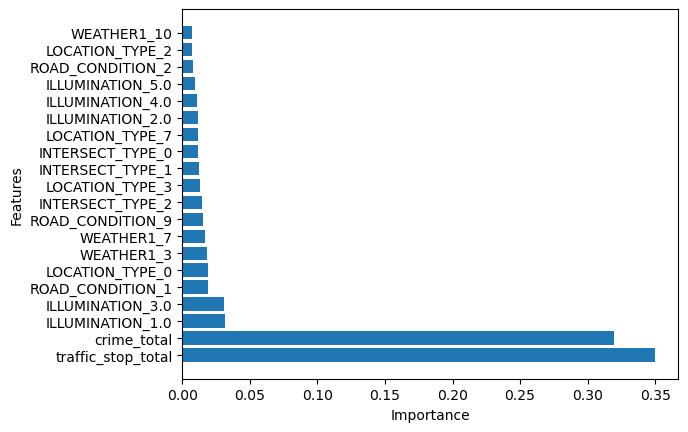

--------- Fold 2 ---------
RMSRE: 0.5888969194183883


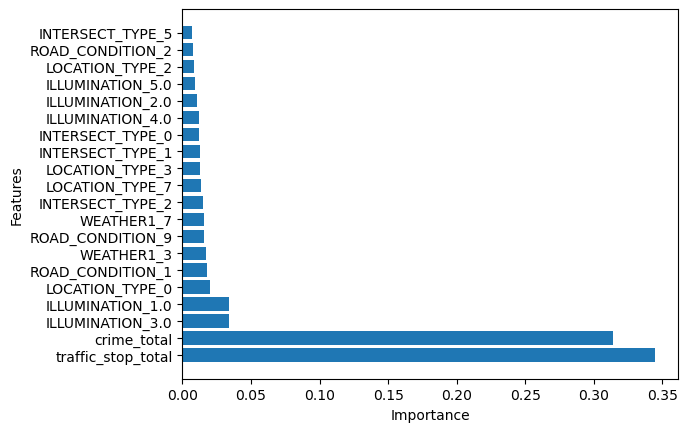

--------- Fold 3 ---------
RMSRE: 0.5996144913693789


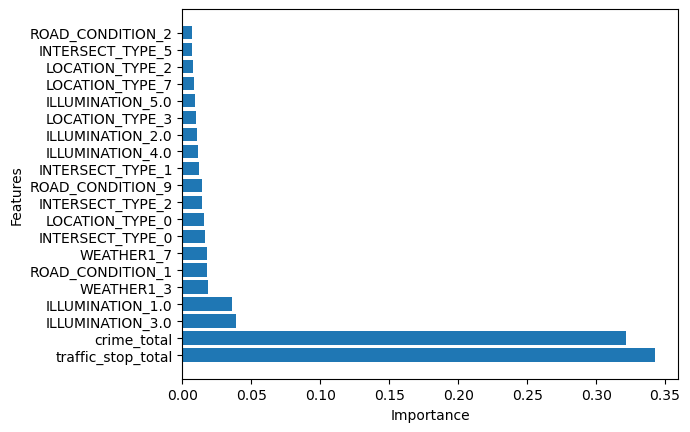

--------- Fold 4 ---------
RMSRE: 0.5900822708512496


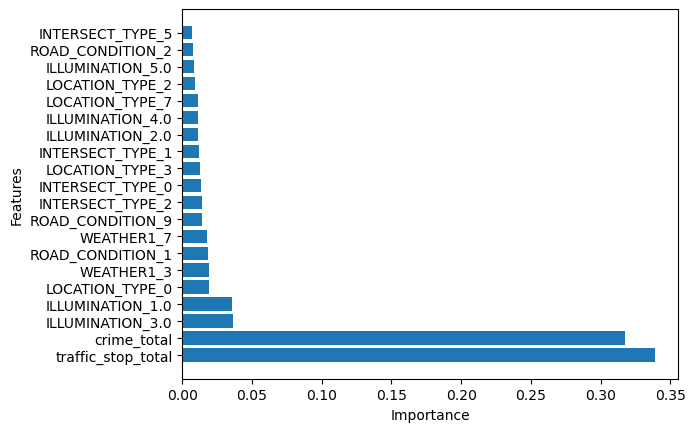

--------- Fold 5 ---------
RMSRE: 0.6272712261539587


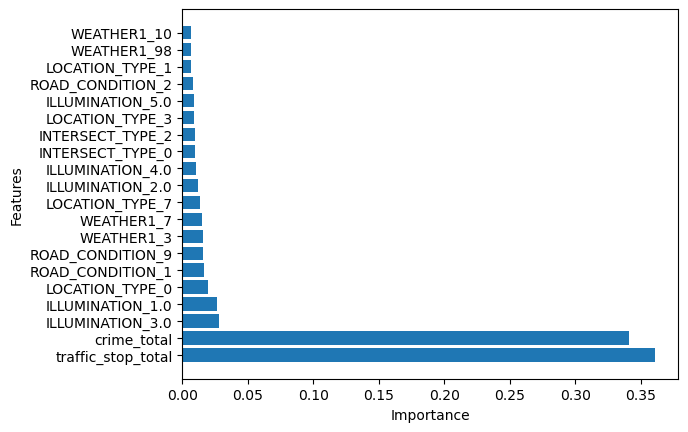

CPU times: user 1min 30s, sys: 980 ms, total: 1min 31s
Wall time: 1min 29s


In [9]:
%%time
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestRegressor

kf = GroupKFold(n_splits=5)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
total = pd.DataFrame()

cnt = 1
for train_index, test_index in kf.split(X, y, groups=df["DIST_NUM"].tolist()):
    print(f"--------- Fold {cnt} ---------")
    X_train, y_train = X.loc[train_index, :], y.loc[train_index]
    X_test, y_test = X.loc[test_index, :], y.loc[test_index]
    cnt += 1
    
    # Create a Random Forest classifier object
    rfc = RandomForestRegressor(random_state=2023)

    # Train the classifier on the training data
    rfc.fit(X_train, y_train)

    # Use the classifier to predict the labels of the test data
    y_pred = rfc.predict(X_test)

    importance = rfc.feature_importances_

    n = len(y_pred)
    mse = 0
    for i in range(n):
        mse += (y_test.to_list()[i] - y_pred[i])**2/y_test.to_list()[i]**2
    mse = np.sqrt(mse/n)
    # mse = mean_squared_error(y_test, y_pred)
    print('RMSRE:', mse)

    
    import matplotlib.pyplot as plt

    features = pd.DataFrame(X_train.columns.to_list())
    features[f'importance_{cnt}'] = importance
    features = features.set_index(features.columns[0])
    features = features.sort_values(f'importance_{cnt}',ascending=False)

    importances_sorted = features.sort_values(f'importance_{cnt}', ascending=False)

    plt.barh(importances_sorted.index[:20], importances_sorted[f'importance_{cnt}'][:20])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()
    total_features = total_features.merge(features, left_on="features", right_index=True, how="left")

In [10]:
total_features["mean_importance"] = total_features[['importance_2', 'importance_3', 'importance_4', 'importance_5', 'importance_6']].mean(axis=1)

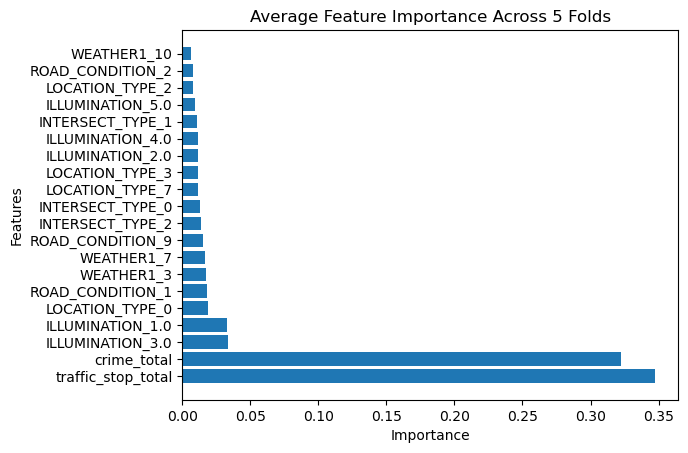

In [11]:
importances_sorted = total_features.sort_values("mean_importance", ascending=False)

plt.barh(importances_sorted["features"][:20], importances_sorted['mean_importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Average Feature Importance Across 5 Folds")
plt.show()

In [12]:
# %%time
# from sklearn.ensemble import RandomForestRegressor

# # Create a Random Forest classifier object
# rfc = RandomForestRegressor(random_state=2023)

# # Train the classifier on the training data
# rfc.fit(X_train, y_train)

# # Use the classifier to predict the labels of the test data
# y_pred = rfc.predict(X_test)

# importance = rfc.feature_importances_

# n = len(y_pred)
# mse = 0
# for i in range(n):
#     mse += (y_test.to_list()[i] - y_pred[i])**2/y_test.to_list()[i]**2
# mse = np.sqrt(mse/n)
# # mse = mean_squared_error(y_test, y_pred)
# print('RMSRE:', mse)

# r2 = r2_score(y_test, y_pred)
# print('R square:', r2)

In [13]:
# import matplotlib.pyplot as plt

# features = pd.DataFrame(X_train.columns.to_list())
# features['importance'] = importance
# features = features.set_index(features.columns[0])
# features = features.sort_values('importance',ascending=False)

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

In [14]:
# df = pd.read_csv("/kaggle/input/data-open-2023-additional-data/merged_data_onehot2.csv")
# df.dropna(inplace=True)
# df.drop(columns={"Unnamed: 0"}, inplace=True)
# df.sort_values(["year_month", "DIST_NUM"], inplace=True)
# df

In [15]:
# X = df.copy()
# X.drop(columns={"DIST_NUM", "year_month", "VEHICLE_COUNT"}, inplace=True)
# y = df["VEHICLE_COUNT"]

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 20)

In [17]:
# # Import the Random Forest classifier
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import r2_score

# dt_regressor = DecisionTreeRegressor(max_features = 10,max_depth =14,random_state = 20)
# dt_regressor.fit(X_train, y_train)
# y_pred = dt_regressor.predict(X_test)

# importance = dt_regressor.feature_importances_

# n = len(y_pred)
# mse = 0
# for i in range(n):
#     mse += (y_test.to_list()[i] - y_pred[i])**2/y_test.to_list()[i]**2
# mse = np.sqrt(mse/n)
# # mse = mean_squared_error(y_test, y_pred)
# print('RMSRE:', mse)

# r2 = r2_score(y_test, y_pred)
# print('R square:', r2)

In [18]:
# import matplotlib.pyplot as plt

# features = pd.DataFrame(X_train.columns.to_list())
# features['importance'] = importance
# features = features.set_index(features.columns[0])
# features = features.sort_values('importance',ascending=False)

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

In [19]:
# import matplotlib.pyplot as plt

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

In [20]:
# from sklearn.ensemble import RandomForestRegressor

# # Create a Random Forest classifier object
# rfc = RandomForestRegressor(random_state=2023)

# # Train the classifier on the training data
# rfc.fit(X_train, y_train)

# # Use the classifier to predict the labels of the test data
# y_pred = rfc.predict(X_test)

# importance = rfc.feature_importances_

# n = len(y_pred)
# mse = 0
# for i in range(n):
#     mse += (y_test.to_list()[i] - y_pred[i])**2/y_test.to_list()[i]**2
# mse = np.sqrt(mse/n)
# # mse = mean_squared_error(y_test, y_pred)
# print('RMSRE:', mse)

# r2 = r2_score(y_test, y_pred)
# print('R square:', r2)

In [21]:
# import matplotlib.pyplot as plt

# features = pd.DataFrame(X_train.columns.to_list())
# features['importance'] = importance
# features = features.set_index(features.columns[0])
# features = features.sort_values('importance',ascending=False)

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

In [22]:
# -

In [23]:
# from scipy.stats import ttest_1samp
# p_values = acorr_ljungbox(residual, lags=[5], boxpierce=False)["lb_pvalue"].values[0]
# # print the p-values
# print("Ljung-Box test p-values:", p_values)

# t_statistic, p_value = ttest_1samp(residual, popmean=0)

# # print the p-value
# print("t-test p-value:", p_value)
# if p_values > 0.05 and p_value > 0.05:
#     print('fail to reject the null hypothesis that the residuals are indenpendent')
#     print('reject the null hypothesis that the mean of residuals are zero')
#     print('Hence, the residuals are independent and have zero mean')

In [24]:
# features = pd.DataFrame(X_train.columns.to_list())
# features['importance'] = importance
# features = features.set_index(features.columns[0])
# features = features.sort_values('importance',ascending=False)

In [25]:
# features.index[:14].tolist()

In [26]:
# import pandas as pd
# pd.read_csv("/kaggle/input/citadel-apac-data-open-2023/APAC_2023_Datasets/Traffic, Investigations _ Other/crimes.csv")["text_general_code"].value_counts()

In [27]:
# features

In [28]:
# import matplotlib.pyplot as plt

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

## After Fitting Remove the Top 14 Features (Which are mostly counts)

In [29]:
# X_train.drop(features.index[:14].tolist(), axis=1, inplace=True)
# X_test.drop(features.index[:14].tolist(), axis=1, inplace=True)

In [30]:
# # Import the Random Forest classifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score

# # Create a Random Forest classifier object
# rfc = RandomForestRegressor(n_estimators=100, random_state=2023)

# # Train the classifier on the training data
# rfc.fit(X_train, y_train)

# # Use the classifier to predict the labels of the test data
# y_pred = rfc.predict(X_test)

In [31]:
# importance = rfc.feature_importances_

# n = len(y_pred)
# mse = 0
# for i in range(n):
#     mse += (y_test.to_list()[i] - y_pred[i])**2/y_test.to_list()[i]**2
# mse = np.sqrt(mse/n)
# # mse = mean_squared_error(y_test, y_pred)
# print('RMSRE:', mse)

# r2 = r2_score(y_test, y_pred)
# print('R square:', r2)

# residual = np.asarray(y_test - y_pred)
# plt.figure(1)
# plt.scatter(range(len(residual)),residual)
# plt.plot(range(len(residual)),np.zeros(len(residual)),'r')
# plt.title('residual')
# fig = sm.qqplot(residual)

In [32]:
# from scipy.stats import ttest_1samp
# p_values = acorr_ljungbox(residual, lags=[5], boxpierce=False)["lb_pvalue"].values[0]
# # print the p-values
# print("Ljung-Box test p-values:", p_values)

# t_statistic, p_value = ttest_1samp(residual, popmean=0)

# # print the p-value
# print("t-test p-value:", p_value)
# if p_values > 0.05 and p_value > 0.05:
#     print('fail to reject the null hypothesis that the residuals are indenpendent')
#     print('reject the null hypothesis that the mean of residuals are zero')
#     print('Hence, the residuals are independent and have zero mean')
    
# features = pd.DataFrame(X_train.columns.to_list())
# features['importance'] = importance
# features = features.set_index(features.columns[0])
# features = features.sort_values('importance',ascending=False)

In [33]:
# import matplotlib.pyplot as plt

# importances_sorted = features.sort_values('importance', ascending=False)

# plt.barh(importances_sorted.index[:20], importances_sorted['importance'][:20])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()